In [20]:
import sys
from os.path import join,expanduser
user_home_dir = expanduser('~')

#point to the correct src path if this doesnt work
sys.path.insert(0,join(user_home_dir,'efs_ecco/ameza/ESS25-Team_SHERLOCCS/src'))

import scipy
import pandas as pd
import matplotlib as mpl
import seaborn as sns
sns.set_theme(context='talk', style='whitegrid')
dpi = 120
mpl.rcParams['figure.dpi'] = dpi
from src import * 

datadir = lambda x: "/efs_ecco/ameza/ESS25-Team_SHERLOCCS/notebooks/heat_budget/data/" + x
plotsdir = lambda x: "/efs_ecco/ameza/ESS25-Team_SHERLOCCS/notebooks/heat_budget/plots/" + x

In [21]:
# main_path = lambda x: join(user_home_dir,'/efs_ecco/ameza' + x)

In [22]:
surf_heat_budget = xr.open_dataset(datadir("mixed_layer_heat_budget.nc"))

subsurf_heat_budget = xr.open_dataset(datadir("subsurface_layer_heat_budget.nc"))

In [23]:
dt = 2678400 #seconds in a month
integrate_dt = lambda dxdt: np.cumsum(np.concatenate((np.array([0.]), dxdt * dt)))

budget_colors = ['black', 'orange', 'blue', 'green', 'purple']


def integrate_monthly_budget_terms(ds,remove_seasonal = False):
    first_year = ds.time[0].dt.year.values
    first_month = ds.time[0].dt.month.values

    nt = len(ds.time)
    time_new= pd.date_range(start=f"{first_year}-{first_month}-01", periods= nt + 1, freq="MS")

    if remove_seasonal: 
        ds_padded = remove_seasonal_cycle(ds).pad(time=(1, 0), constant_values=0)
    else: 
        ds_padded = ds.pad(time=(1, 0), constant_values=0)
        
    integrated_ds = (ds_padded* dt).cumsum()
    integrated_ds.coords["time"] = time_new
    return integrated_ds
def plot_integrated_heat_budget(fig, ax, ds, remove_seasonal = False):
    integrated_budget = integrate_monthly_budget_terms(ds, remove_seasonal = remove_seasonal)

    integrated_budget["LHS"].plot(ax = ax, label = "Temperature Anomaly", c = budget_colors[0])

    integrated_budget["G_SURF"].plot(ax = ax, label = "Surface Forcing Contr.", c=budget_colors[1])
    integrated_budget["G_ADV"].plot(ax = ax, label = "Advection Contr.", c=budget_colors[2])
    integrated_budget["G_DIF"].plot(ax = ax, label = "Diffusion Contr.", c=budget_colors[3])
    integrated_budget["G_GEO"].plot(ax = ax, label = "Geothermal Contr.", c=budget_colors[4])

    ax.set_ylabel("[deg C]")
    ax.grid(alpha = 0.2)

def plot_mean_heat_budget(fig, ax, ds, convert_power_density = False, H = np.nan):
    rho0 = 1025
    cp = 3990 
    if convert_power_density:
        ds_mean = rho0 * cp * H * ds.mean("time")
        ax.set_ylabel("Rate of Change of Heat \n" + r"[W/m$^{2}$]")
    else: 
        ds_mean = ds.mean("time")
        ax.set_ylabel("Rate of Change of Heat\n[deg C per second]")

    variable_names = ["LHS", "G_SURF", "G_ADV", "G_DIF", "G_GEO"]
    variable_labels = ["TTEND", "TFLUX", "ADV", "DIF", "GEO"]
    
    values = [ds_mean[var].values.item() for var in variable_names]

    ax.bar(variable_labels, values, color = budget_colors, edgecolor='black')
    

    ax.grid(alpha = 0.2)
    ax.tick_params(axis='x', rotation=45)


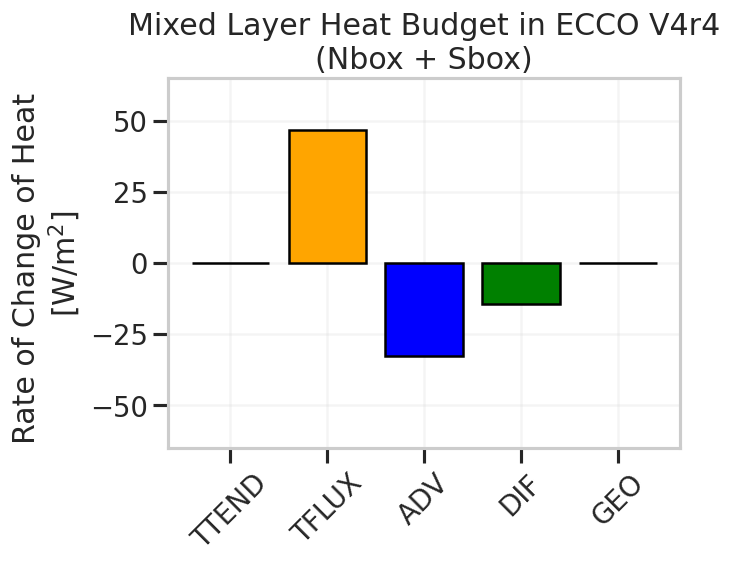

In [25]:
fig, ax = plt.subplots(figsize = (5.5, 4))
plot_mean_heat_budget(fig, ax, surf_heat_budget.sel(time = slice("2007", "2013")), 
                      convert_power_density = True, H = 50)
ax.set_ylim(-65, 65)
ax.tick_params(
    axis="both",        # apply to the y-axis
    which="both",    # both major and minor ticks
    left=True,       # turn left ticks on
    right=False,     # turn right ticks off
    bottom = True,
    labelleft=True   # show labels on the left
)
ax.set_title("Mixed Layer Heat Budget in ECCO V4r4\n(Nbox + Sbox)")
fig.savefig(plotsdir("Mixed_Layer_Heat_Budget_2007_2013.png"), dpi = dpi, bbox_inches = "tight" )

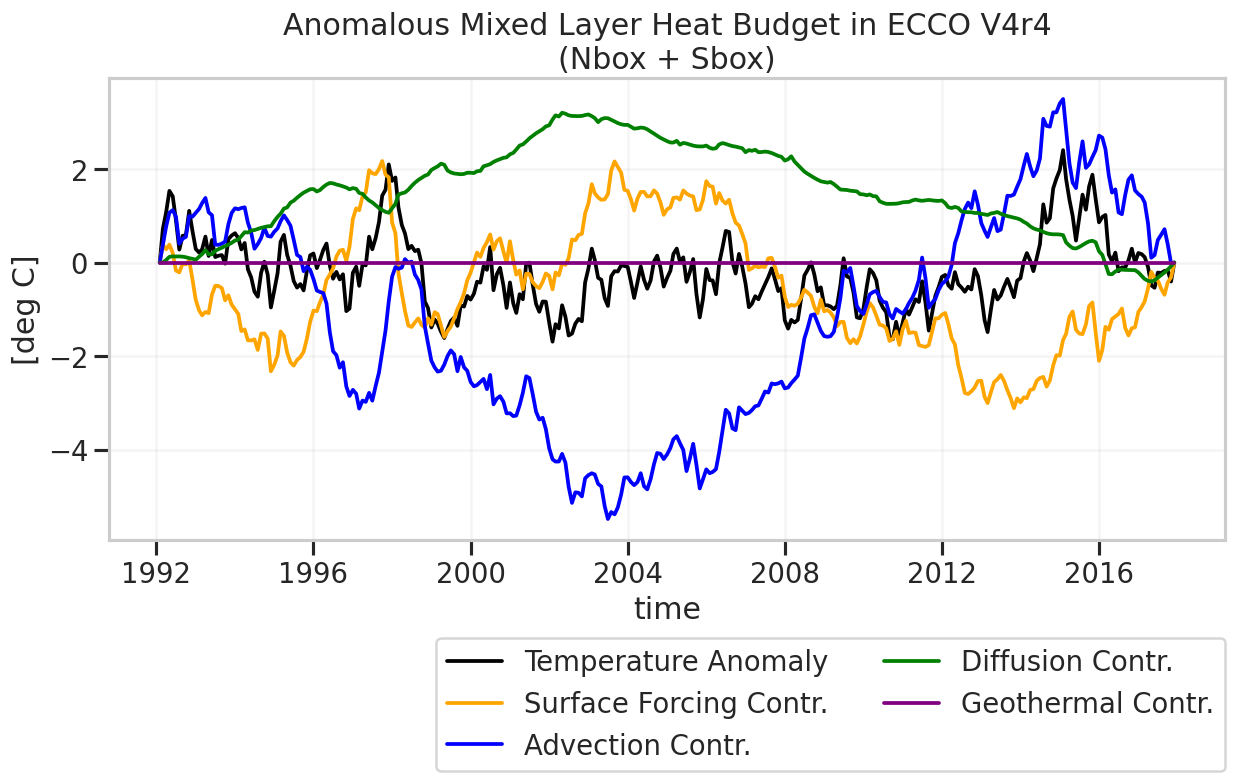

In [26]:
fig, ax = plt.subplots(figsize = (12, 5))
plot_integrated_heat_budget(fig, ax, surf_heat_budget, remove_seasonal = True)
ax.tick_params(
    axis="both",        # apply to the y-axis
    which="both",    # both major and minor ticks
    left=True,       # turn left ticks on
    right=False,     # turn right ticks off
    bottom = True,
    labelleft=True   # show labels on the left
)
# place legend outside the axes
ax.legend(
    ncols=2,
    loc="lower right",
    bbox_to_anchor=(1.00, -0.5),   # x=1.02 puts it just right of the axes; y=1 aligns top
    borderaxespad=0, # no padding between axes and legend box
    frameon = True
)

ax.set_title("Anomalous Mixed Layer Heat Budget in ECCO V4r4\n(Nbox + Sbox)")
fig.savefig(plotsdir("Anom_Mixed_Layer_Heat_Budget_Timeseries.png"), dpi = dpi, bbox_inches = "tight" )

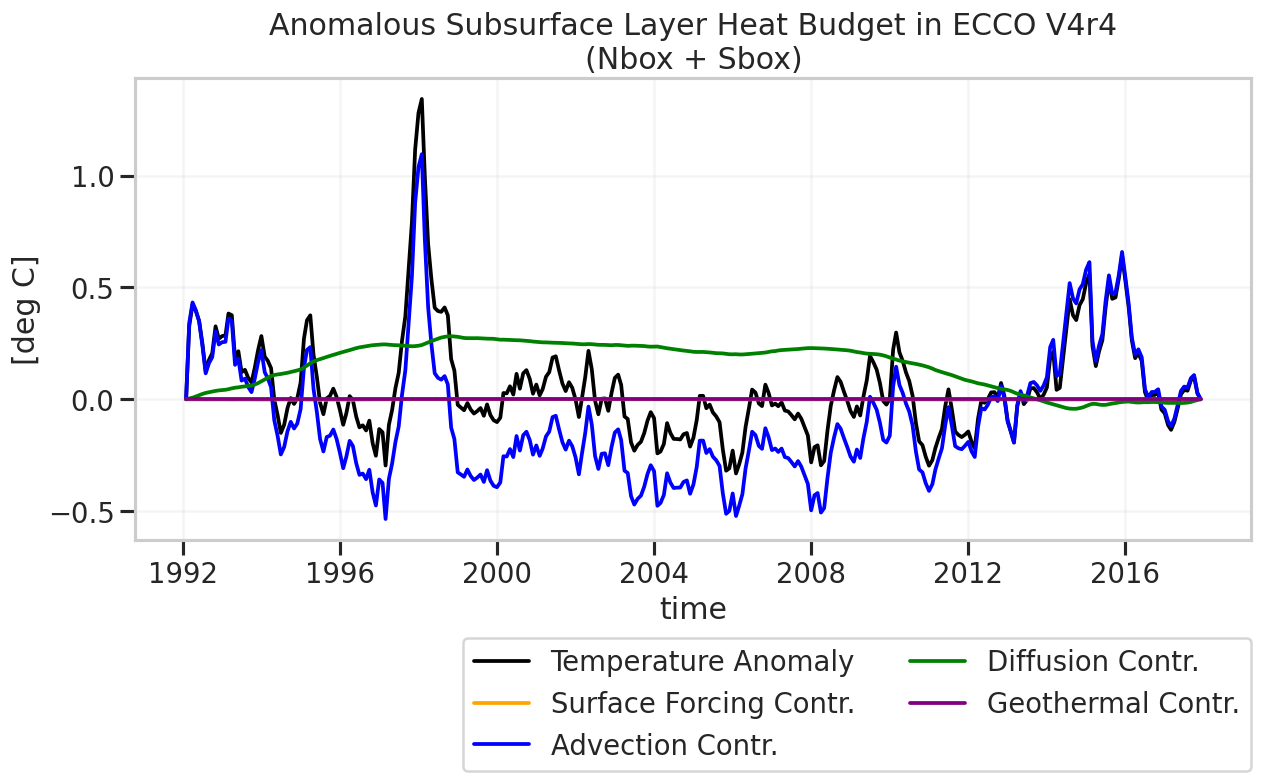

In [27]:
fig, ax = plt.subplots(figsize = (12, 5))
plot_integrated_heat_budget(fig, ax, subsurf_heat_budget, remove_seasonal = True)
ax.tick_params(
    axis="both",        # apply to the y-axis
    which="both",    # both major and minor ticks
    left=True,       # turn left ticks on
    right=False,     # turn right ticks off
    bottom = True,
    labelleft=True   # show labels on the left
)
# place legend outside the axes
ax.legend(
    ncols=2,
    loc="lower right",
    bbox_to_anchor=(1.00, -0.5),   # x=1.02 puts it just right of the axes; y=1 aligns top
    borderaxespad=0, # no padding between axes and legend box
    frameon = True
)
ax.set_title("Anomalous Subsurface Layer Heat Budget in ECCO V4r4\n(Nbox + Sbox)")
fig.savefig(plotsdir("Anom_Subsurf_Layer_Heat_Budget_Timeseries.png"), dpi = dpi, bbox_inches = "tight" )